In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, accuracy_score
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import os
import psutil
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score, roc_curve
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, random_split

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [2]:
# 1. Set up device for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# 2. Define transformations and data augmentation (simplified)
transform = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# 3. Load datasets
data_dir = 'C:/Users/bhuva/Desktop/crop_resnet_model/dataset/PlantVillage_Balanced'
batch_size = 32

# Load Dataset and Split into Train, Val, Test
dataset = datasets.ImageFolder(data_dir, transform=transform["train"])
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Apply appropriate transformations
train_dataset.dataset.transform = transform["train"]
val_dataset.dataset.transform = transform["val"]
test_dataset.dataset.transform = transform["val"]

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# 4. Define model with pretrained weights (simpler model)
model = models.resnet18(weights='IMAGENET1K_V1')  # Changed to ResNet18
model.fc = nn.Linear(model.fc.in_features, 15)  # Set number of classes
model = model.to(device)

# 5. Hyperparameters and optimizer settings
num_epochs = 18  # Adjusted to a reasonable number
criterion = nn.CrossEntropyLoss()
learning_rate = 1e-3  # Increased learning rate
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
early_stopping_patience = 15  # Adjusted for a shorter patience





cuda


c:\Users\bhuva\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
 # 6. Initialize logging for training metrics
train_log = []
best_val_loss = np.inf
patience_counter = 0

# 7. Training loop with progress bar and logging
for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    epoch_start_time = time.time()
    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")

    for images, labels in train_pbar:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_acc = correct / total
    val_loss, val_acc = 0.0, 0.0

    # Validation
    model.eval()
    
    with torch.no_grad():
        correct, total = 0, 0
        val_running_loss = 0.0
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            
        val_loss = val_running_loss / total
        val_acc = correct / total

    scheduler.step(val_loss)

    # Document metrics
    epoch_time = time.time() - epoch_start_time
    train_log.append({
        'epoch': epoch + 1, 'train_loss': train_loss, 'train_acc': train_acc, 
        'val_loss': val_loss, 'val_acc': val_acc, 'epoch_time': epoch_time
    })

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'crop_disease_simple_undersample2.pth')
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print("Early stopping triggered.")
            break

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

# Save logs to CSV
pd.DataFrame(train_log).to_csv("training_log_simple_undersample2.csv", index=False)

Epoch 1/18: 100%|██████████| 50/50 [00:35<00:00,  1.42batch/s]


Epoch 1/18 - Train Loss: 0.9069, Train Acc: 0.7312, Val Loss: 1.1777, Val Acc: 0.7251


Epoch 2/18: 100%|██████████| 50/50 [00:37<00:00,  1.35batch/s]


Epoch 2/18 - Train Loss: 0.4290, Train Acc: 0.8640, Val Loss: 0.3942, Val Acc: 0.8801


Epoch 3/18: 100%|██████████| 50/50 [00:32<00:00,  1.54batch/s]


Epoch 3/18 - Train Loss: 0.2392, Train Acc: 0.9273, Val Loss: 0.7601, Val Acc: 0.7778


Epoch 4/18: 100%|██████████| 50/50 [00:29<00:00,  1.67batch/s]


Epoch 4/18 - Train Loss: 0.1949, Train Acc: 0.9405, Val Loss: 0.5459, Val Acc: 0.8275


Epoch 5/18: 100%|██████████| 50/50 [00:27<00:00,  1.85batch/s]


Epoch 5/18 - Train Loss: 0.1482, Train Acc: 0.9536, Val Loss: 0.3846, Val Acc: 0.8772


Epoch 6/18: 100%|██████████| 50/50 [00:27<00:00,  1.81batch/s]


Epoch 6/18 - Train Loss: 0.1014, Train Acc: 0.9649, Val Loss: 0.3189, Val Acc: 0.8918


Epoch 7/18: 100%|██████████| 50/50 [00:25<00:00,  1.98batch/s]


Epoch 7/18 - Train Loss: 0.0932, Train Acc: 0.9712, Val Loss: 0.8966, Val Acc: 0.7632


Epoch 8/18: 100%|██████████| 50/50 [00:28<00:00,  1.77batch/s]


Epoch 8/18 - Train Loss: 0.1105, Train Acc: 0.9630, Val Loss: 0.3598, Val Acc: 0.8421


Epoch 9/18: 100%|██████████| 50/50 [00:31<00:00,  1.57batch/s]


Epoch 9/18 - Train Loss: 0.0540, Train Acc: 0.9862, Val Loss: 0.1540, Val Acc: 0.9561


Epoch 10/18: 100%|██████████| 50/50 [00:29<00:00,  1.70batch/s]


Epoch 10/18 - Train Loss: 0.0211, Train Acc: 0.9950, Val Loss: 0.2522, Val Acc: 0.9123


Epoch 11/18: 100%|██████████| 50/50 [00:27<00:00,  1.79batch/s]


Epoch 11/18 - Train Loss: 0.0402, Train Acc: 0.9868, Val Loss: 0.2101, Val Acc: 0.9298


Epoch 12/18: 100%|██████████| 50/50 [00:25<00:00,  1.95batch/s]


Epoch 12/18 - Train Loss: 0.0312, Train Acc: 0.9925, Val Loss: 0.2321, Val Acc: 0.9240


Epoch 13/18: 100%|██████████| 50/50 [00:27<00:00,  1.80batch/s]


Epoch 13/18 - Train Loss: 0.0487, Train Acc: 0.9831, Val Loss: 0.4704, Val Acc: 0.8713


Epoch 14/18: 100%|██████████| 50/50 [00:26<00:00,  1.90batch/s]


Epoch 14/18 - Train Loss: 0.1007, Train Acc: 0.9687, Val Loss: 0.2940, Val Acc: 0.9181


Epoch 15/18: 100%|██████████| 50/50 [00:30<00:00,  1.62batch/s]


Epoch 15/18 - Train Loss: 0.0448, Train Acc: 0.9875, Val Loss: 0.3233, Val Acc: 0.9240


Epoch 16/18: 100%|██████████| 50/50 [00:27<00:00,  1.84batch/s]


Epoch 16/18 - Train Loss: 0.0292, Train Acc: 0.9925, Val Loss: 0.1219, Val Acc: 0.9649


Epoch 17/18: 100%|██████████| 50/50 [00:26<00:00,  1.86batch/s]


Epoch 17/18 - Train Loss: 0.0158, Train Acc: 0.9937, Val Loss: 0.1510, Val Acc: 0.9561


Epoch 18/18: 100%|██████████| 50/50 [00:27<00:00,  1.81batch/s]


Epoch 18/18 - Train Loss: 0.0073, Train Acc: 0.9981, Val Loss: 0.1060, Val Acc: 0.9561


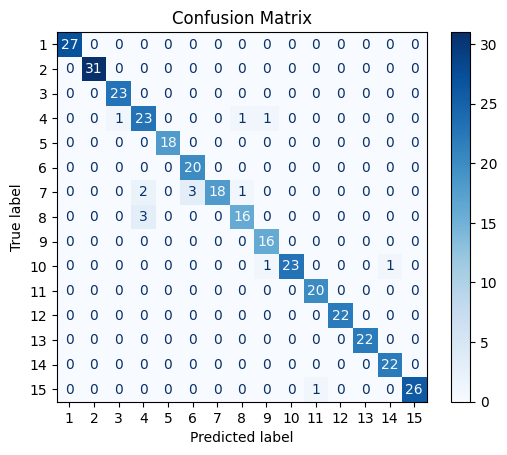

In [4]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

class_names = ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15']


# Function to evaluate the model and plot the confusion matrix
def plot_confusion_matrix(model, dataloader, device, class_names):
    all_preds = []
    all_labels = []
    
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # No gradients needed for validation
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)  # Get the predicted class
            
            all_preds.extend(predicted.cpu().numpy())  # Collect predictions
            all_labels.extend(labels.cpu().numpy())    # Collect true labels

    # Compute the confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    
    
    # Plotting the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

# After training, call the function
plot_confusion_matrix(model, val_loader, device, class_names)

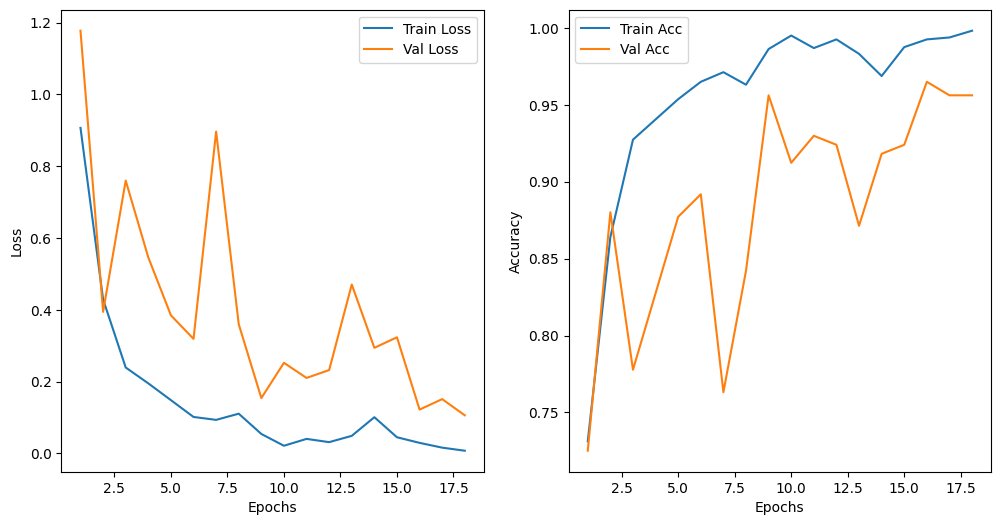

In [5]:
# 8. Plot training history
history_df = pd.DataFrame(train_log)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_df['epoch'], history_df['train_loss'], label='Train Loss')
plt.plot(history_df['epoch'], history_df['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_df['epoch'], history_df['train_acc'], label='Train Acc')
plt.plot(history_df['epoch'], history_df['val_acc'], label='Val Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


cuda


C:\Users\bhuva\AppData\Local\Temp\ipykernel_4640\1655818965.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('crop_disease_simple_unders

                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       1.00      1.00      1.00       152
                     Pepper__bell___healthy       1.00      1.00      1.00       152
                      Potato___Early_blight       0.99      1.00      0.99       152
                       Potato___Late_blight       0.94      0.98      0.96       152
                           Potato___healthy       1.00      1.00      1.00       152
                      Tomato_Bacterial_spot       0.96      1.00      0.98       152
                        Tomato_Early_blight       0.99      0.95      0.97       152
                         Tomato_Late_blight       0.99      0.95      0.97       152
                           Tomato_Leaf_Mold       0.98      1.00      0.99       152
                  Tomato_Septoria_leaf_spot       1.00      0.96      0.98       152
Tomato_Spider_mites_Two_spotted_spider_mite       0.98      0.99

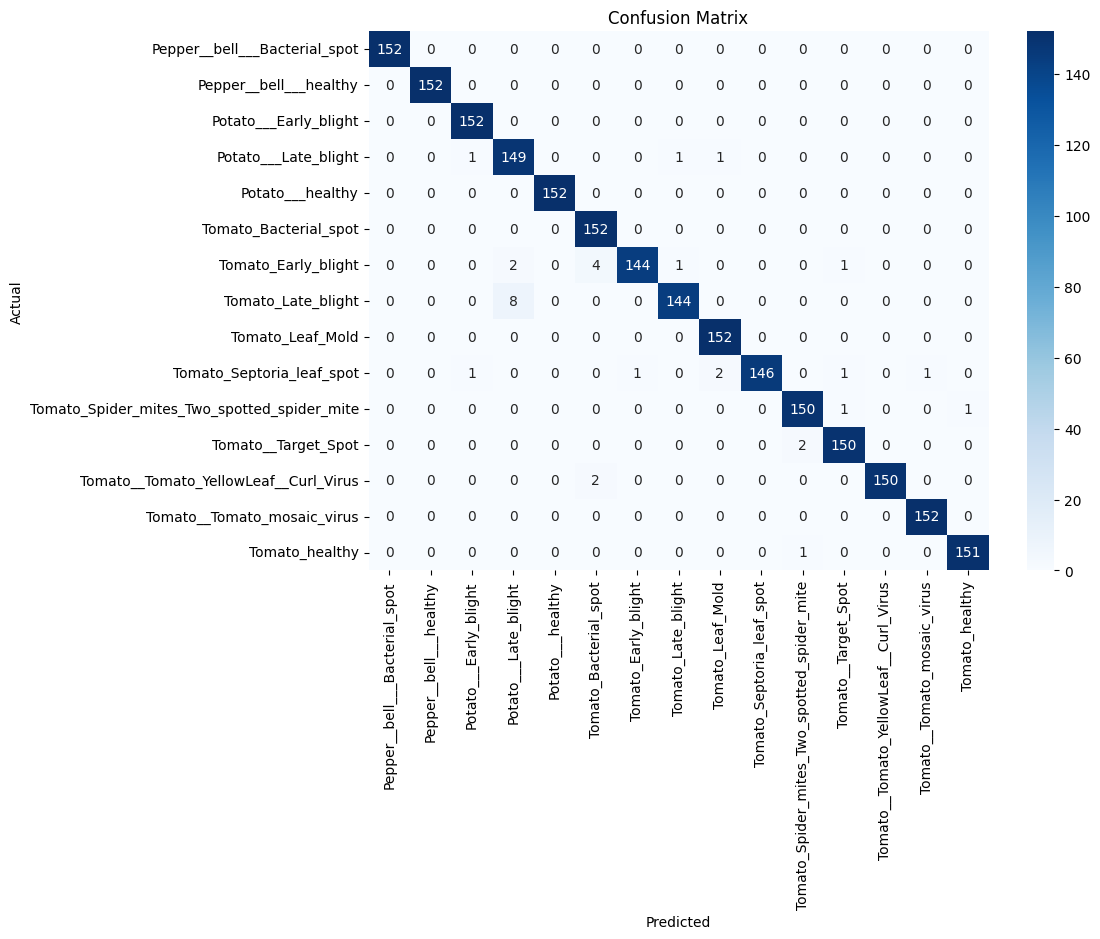

In [2]:
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, models

# 1. Set up device for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# 2. Define transformations for evaluation
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# 3. Load test dataset
data_dir = 'C:/Users/bhuva/Desktop/crop_resnet_model/dataset/PlantVillage_Balanced'
test_dataset = datasets.ImageFolder(data_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

# 4. Load the trained model
model = models.resnet18(weights='IMAGENET1K_V1')
model.fc = nn.Linear(model.fc.in_features, 15)  # Set number of classes to 15
model.load_state_dict(torch.load('crop_disease_simple_undersample2.pth'))  # Load the best model
model = model.to(device)
model.eval()

# 5. Evaluation
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        # Collect labels and predictions
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# Convert to numpy arrays for metrics calculations
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

# 6. Print classification report
print(classification_report(all_labels, all_preds, target_names=test_dataset.classes))

# 7. Print confusion matrix
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:\n", cm)

# Optionally, visualize the confusion matrix with a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_dataset.classes,
            yticklabels=test_dataset.classes)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# 8. Function to recognize a single image
def recognize_disease(image_path):
    model.eval()
    image = Image.open(image_path)  # Load the image
    image = transform(image).unsqueeze(0).to(device)  # Apply transformations and add batch dimension

    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)
        class_index = predicted.item()
        return test_dataset.classes[class_index]  # Return the class name

# Example usage for recognizing disease in a single image
# image_path = "path_to_your_test_image.jpg"
# print(f"Predicted disease: {recognize_disease(image_path)}")
